In [23]:
from quantum_error_correction_code import SurfaceCode, deformation_cmap
from neural_network import CNNDual, load_params

from environment import EnvironmentNoiselessCNN

import jax.numpy as jnp
from jax import random
from time import time
import matplotlib.pyplot as plt

key = random.key(32)

In [2]:
settings, model_params = load_params("data/general_distance3_decoder.json")
print(settings.keys())

CODE_DISTANCE = settings["CODE_DISTANCE"]
print(f"{CODE_DISTANCE = }")

DEFORMATION_OPTIONS = settings["DEFORMATION_OPTIONS"]
print(f"{DEFORMATION_OPTIONS = }")

ERROR_PROBS = settings["ERROR_PROBS"]
print(f"{ERROR_PROBS = }")

CONV_LAYERS_INPUT_1 = [tuple(int(v) for v in elm) for elm in settings["CONV_LAYERS_INPUT_1"]]
print(f"{CONV_LAYERS_INPUT_1 = }")

CONV_LAYERS_INPUT_2 = [tuple(int(v) for v in elm) for elm in settings["CONV_LAYERS_INPUT_2"]]
print(f"{CONV_LAYERS_INPUT_2 = }")

CONV_LAYERS_STAGE_2 = [tuple(int(v) for v in elm) for elm in settings["CONV_LAYERS_STAGE_2"]]
print(f"{CONV_LAYERS_STAGE_2 = }")

FC_LAYERS = settings["FC_LAYERS"].tolist()
print(f"{FC_LAYERS = }")

CODE_DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32)

dict_keys(['CODE_DISTANCE', 'DEFORMATION_OPTIONS', 'ERROR_PROBS', 'CONV_LAYERS_INPUT_1', 'CONV_LAYERS_INPUT_2', 'CONV_LAYERS_STAGE_2', 'FC_LAYERS'])
CODE_DISTANCE = 3
DEFORMATION_OPTIONS = Array([0, 1, 2, 3, 4, 5], dtype=int32)
ERROR_PROBS = Array([9.98004e-06, 9.98004e-06, 9.98004e-03], dtype=float32)
CONV_LAYERS_INPUT_1 = [(8, 2, 1, 0)]
CONV_LAYERS_INPUT_2 = [(8, 1, 1, 0)]
CONV_LAYERS_STAGE_2 = [(8, 2, 1, 0)]
FC_LAYERS = [50, 2]


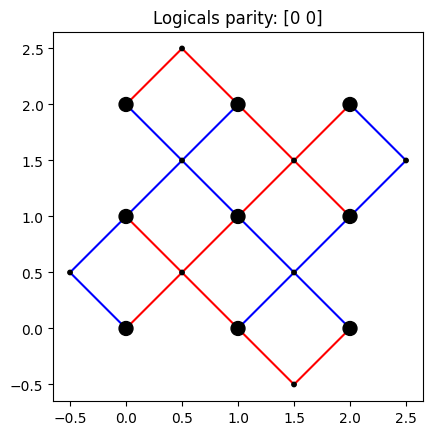

In [3]:
code = SurfaceCode(CODE_DISTANCE)
parity_info = code.deformation_parity_info(CODE_DEFORMATION)
code.show(parity_info)

In [4]:
model = CNNDual(
    input_shape_1 = (1, CODE_DISTANCE+1, CODE_DISTANCE+1),
    input_shape_2 = (6, CODE_DISTANCE, CODE_DISTANCE),
    conv_layers_input_1 = CONV_LAYERS_INPUT_1,
    conv_layers_input_2 = CONV_LAYERS_INPUT_2,
    conv_layers_stage_2 = CONV_LAYERS_STAGE_2,
    fc_layers = FC_LAYERS
)
model.layer_sizes

{'CNN_input_1': [(1, 4, 4), (8, 3, 3)],
 'CNN_input_2': [(6, 3, 3), (8, 3, 3)],
 'CNN_stage_2': [(8, 3, 3), (8, 2, 2)],
 'MLP_stage_3': [32, 50, 2]}

In [5]:
env = EnvironmentNoiselessCNN(
    model=model,
    model_params=model_params,
    noise_model=ERROR_PROBS,
    code=code,
)

In [6]:
env._state_score(key, jnp.array([3, 2, 1, 2, 2, 3, 2, 0, 2]))[0] # = 401.46786 (optimal result)

2025-03-20 11:31:36.853246: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %slice.6 = s32[262144,1,9]{2,1,0} slice(s32[262144,2,9]{2,1,0} %constant.5), slice={[0:262144], [0:1], [0:9]}, metadata={op_name="jit(_get_state_error_rate)/jit(main)/vmap(jit(_syndrome_img))/jit(_syndrome)/slice" source_file="/home/Julius/Documents/alumni/Thesis/QEC/Modules/quantum_error_correction_code.py" source_line=185}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-03-20 11:31:37.014939: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.161842894s
Constant folding an in

Array(116.74076, dtype=float32)

In [7]:
state, score, key = env.reset(key)
score

Array(5.8133507, dtype=float32)

In [8]:
time_limit = 10
sample_count = 0
t0 = time()
while time() - t0 < time_limit:
    state, score, key = env.reset(key)
    sample_count = sample_count + 1
print(f"Average execution time = {(time()-t0)/sample_count:.3f}s per noiseless estimate ({sample_count} samples)")

Average execution time = 0.167s per noiseless estimate (60 samples)


In [9]:
scores = []
for i in range(100):
    state, score, key = env.reset(key)
    scores.append(score)

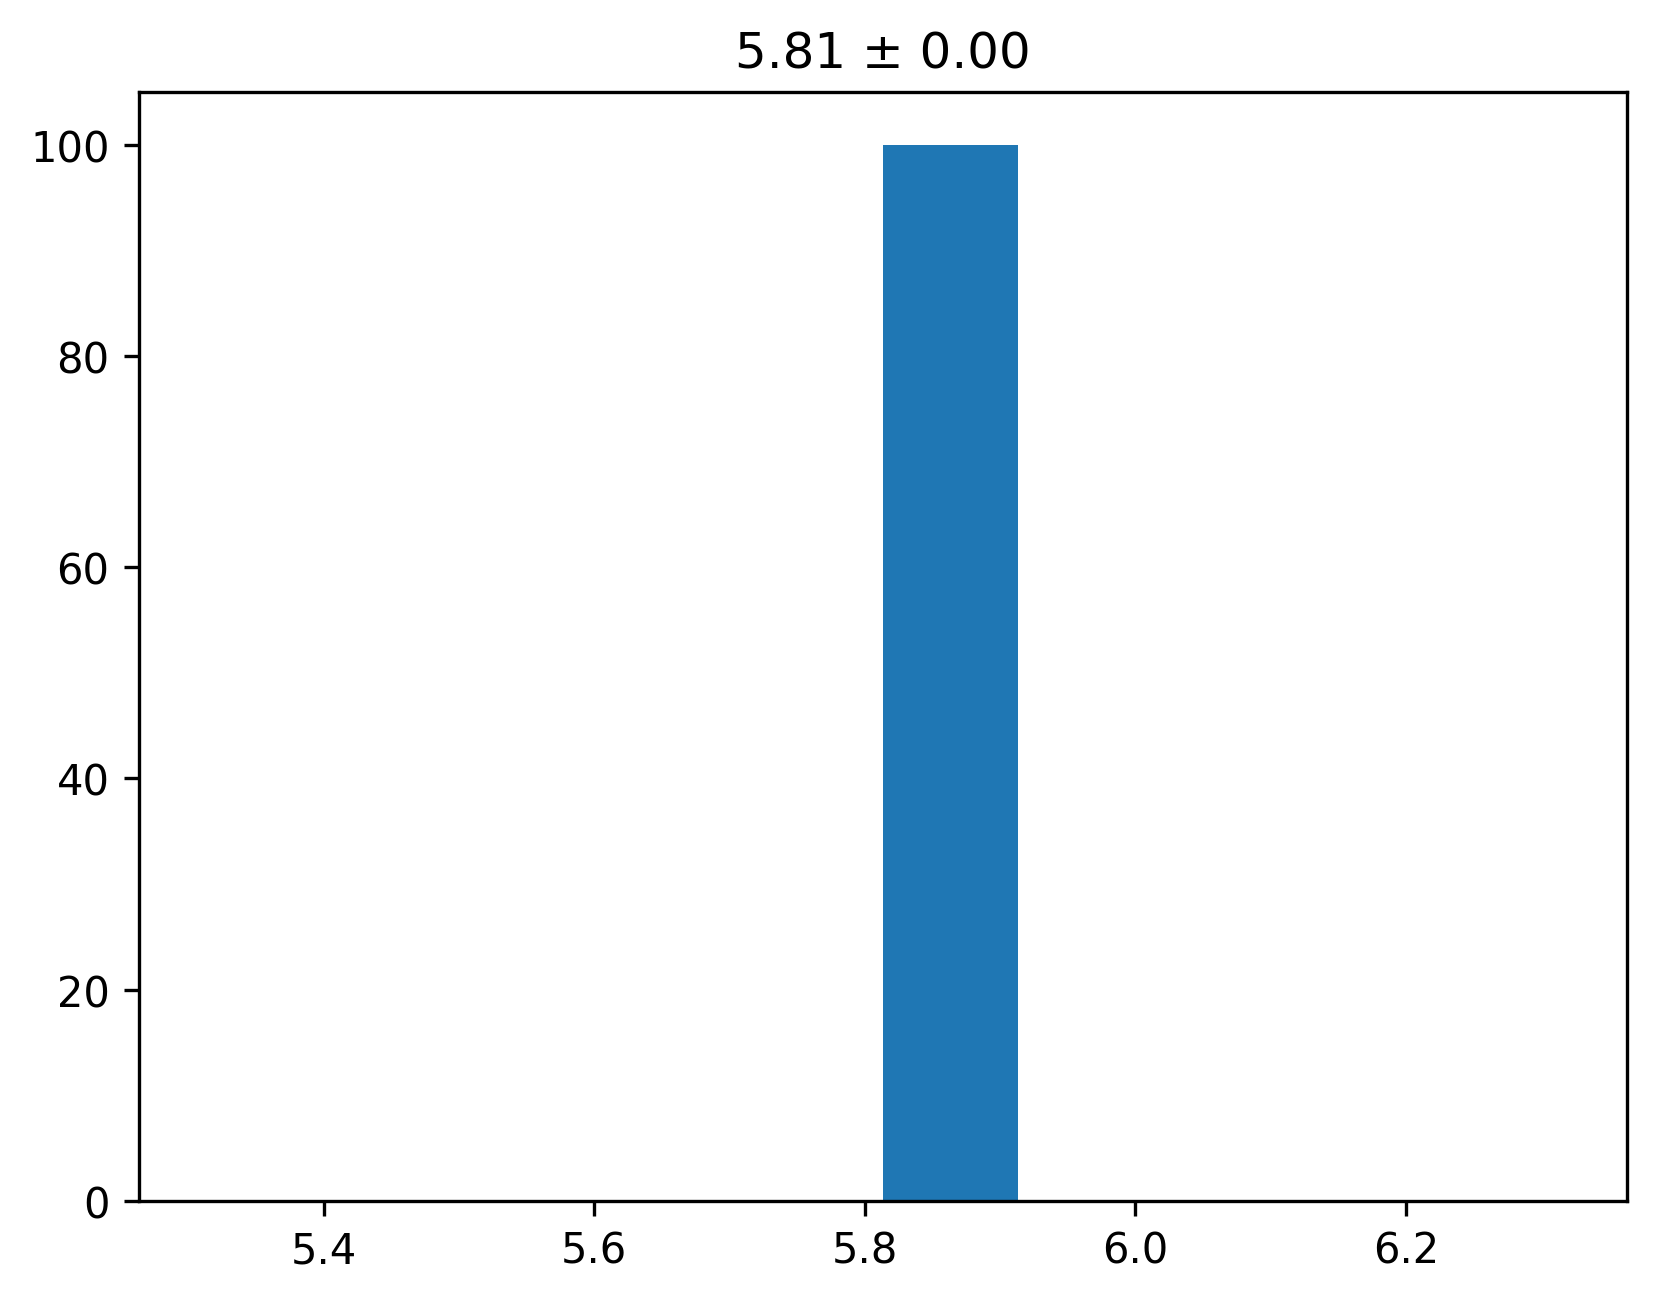

In [10]:
import matplotlib.pyplot as plt

x = jnp.array(scores)

plt.figure(dpi=300)
plt.title(f"{x.mean():.2f} ± {x.std():.2f}")
plt.hist(x)
plt.show()

# Make graph

In [11]:
deformations_included = jnp.array([0,2,3])
m = deformations_included.shape[0] # Number of diferent deformations per qubit
n = code.hx_original.shape[1] # Number of data qubits that can have deformations
all_deformations = jnp.zeros(shape=(m**n, n), dtype=jnp.int32) + jnp.arange(0, m**n)[:, None]
all_deformations = (all_deformations // m**jnp.arange(0, n)) % m
all_deformations = deformations_included[all_deformations]
print(all_deformations.shape)
print(all_deformations)

(19683, 9)
[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [0 3 3 ... 3 3 3]
 [2 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


In [ ]:
from jax import vmap
from time import time
t0 = time()

all_logical_error_rates = jnp.zeros(all_deformations.shape[0])*
batch_size = m**3
for i, deformations_batch in enumerate(all_deformations.reshape((-1, batch_size, n))):
    all_logical_error_rates = all_logical_error_rates.at[i*batch_size:(i+1)*batch_size].set(
        vmap(env._get_state_error_rate, in_axes=(None, 0))(key, deformations_batch)[0]
    )
    procentage = (i+1) / (all_deformations.shape[0] // batch_size)
    remaining_time = (time()-t0) / procentage * (1 - procentage)
    print(f"{int(remaining_time/60/60):5d}h {int(remaining_time/60%60):02d}m {int(remaining_time%60):02d}s    ({procentage:.2%})"+10*" ", end='\r')
total_time = time()-t0
print(f"Total time used = {int(total_time/60/60):5d}h {int(total_time/60%60):02d}m {int(total_time%60):02d}s"+50*" ", end='\r')
jnp.save("data/environmentNoiselessCNN_error_rates_p01_nu500_halve.npy", all_logical_error_rates)

In [ ]:
all_logical_error_rates = jnp.load("data/environmentNoiselessCNN_error_rates_p01_nu500_halve.npy")

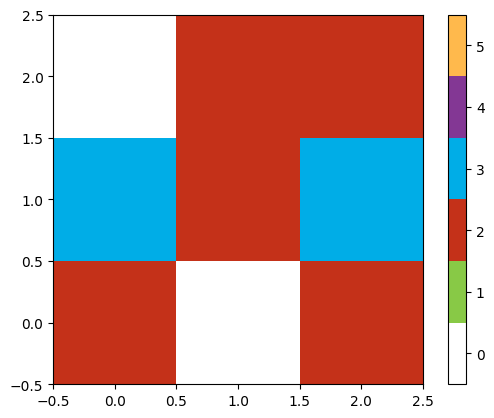

In [27]:
optimal_deformation = all_deformations[all_logical_error_rates.argmin()]

plt.figure()
plt.imshow(optimal_deformation.reshape(3,3), origin='lower', cmap=deformation_cmap, vmin=-.5, vmax=5.5)
plt.colorbar()
plt.show()

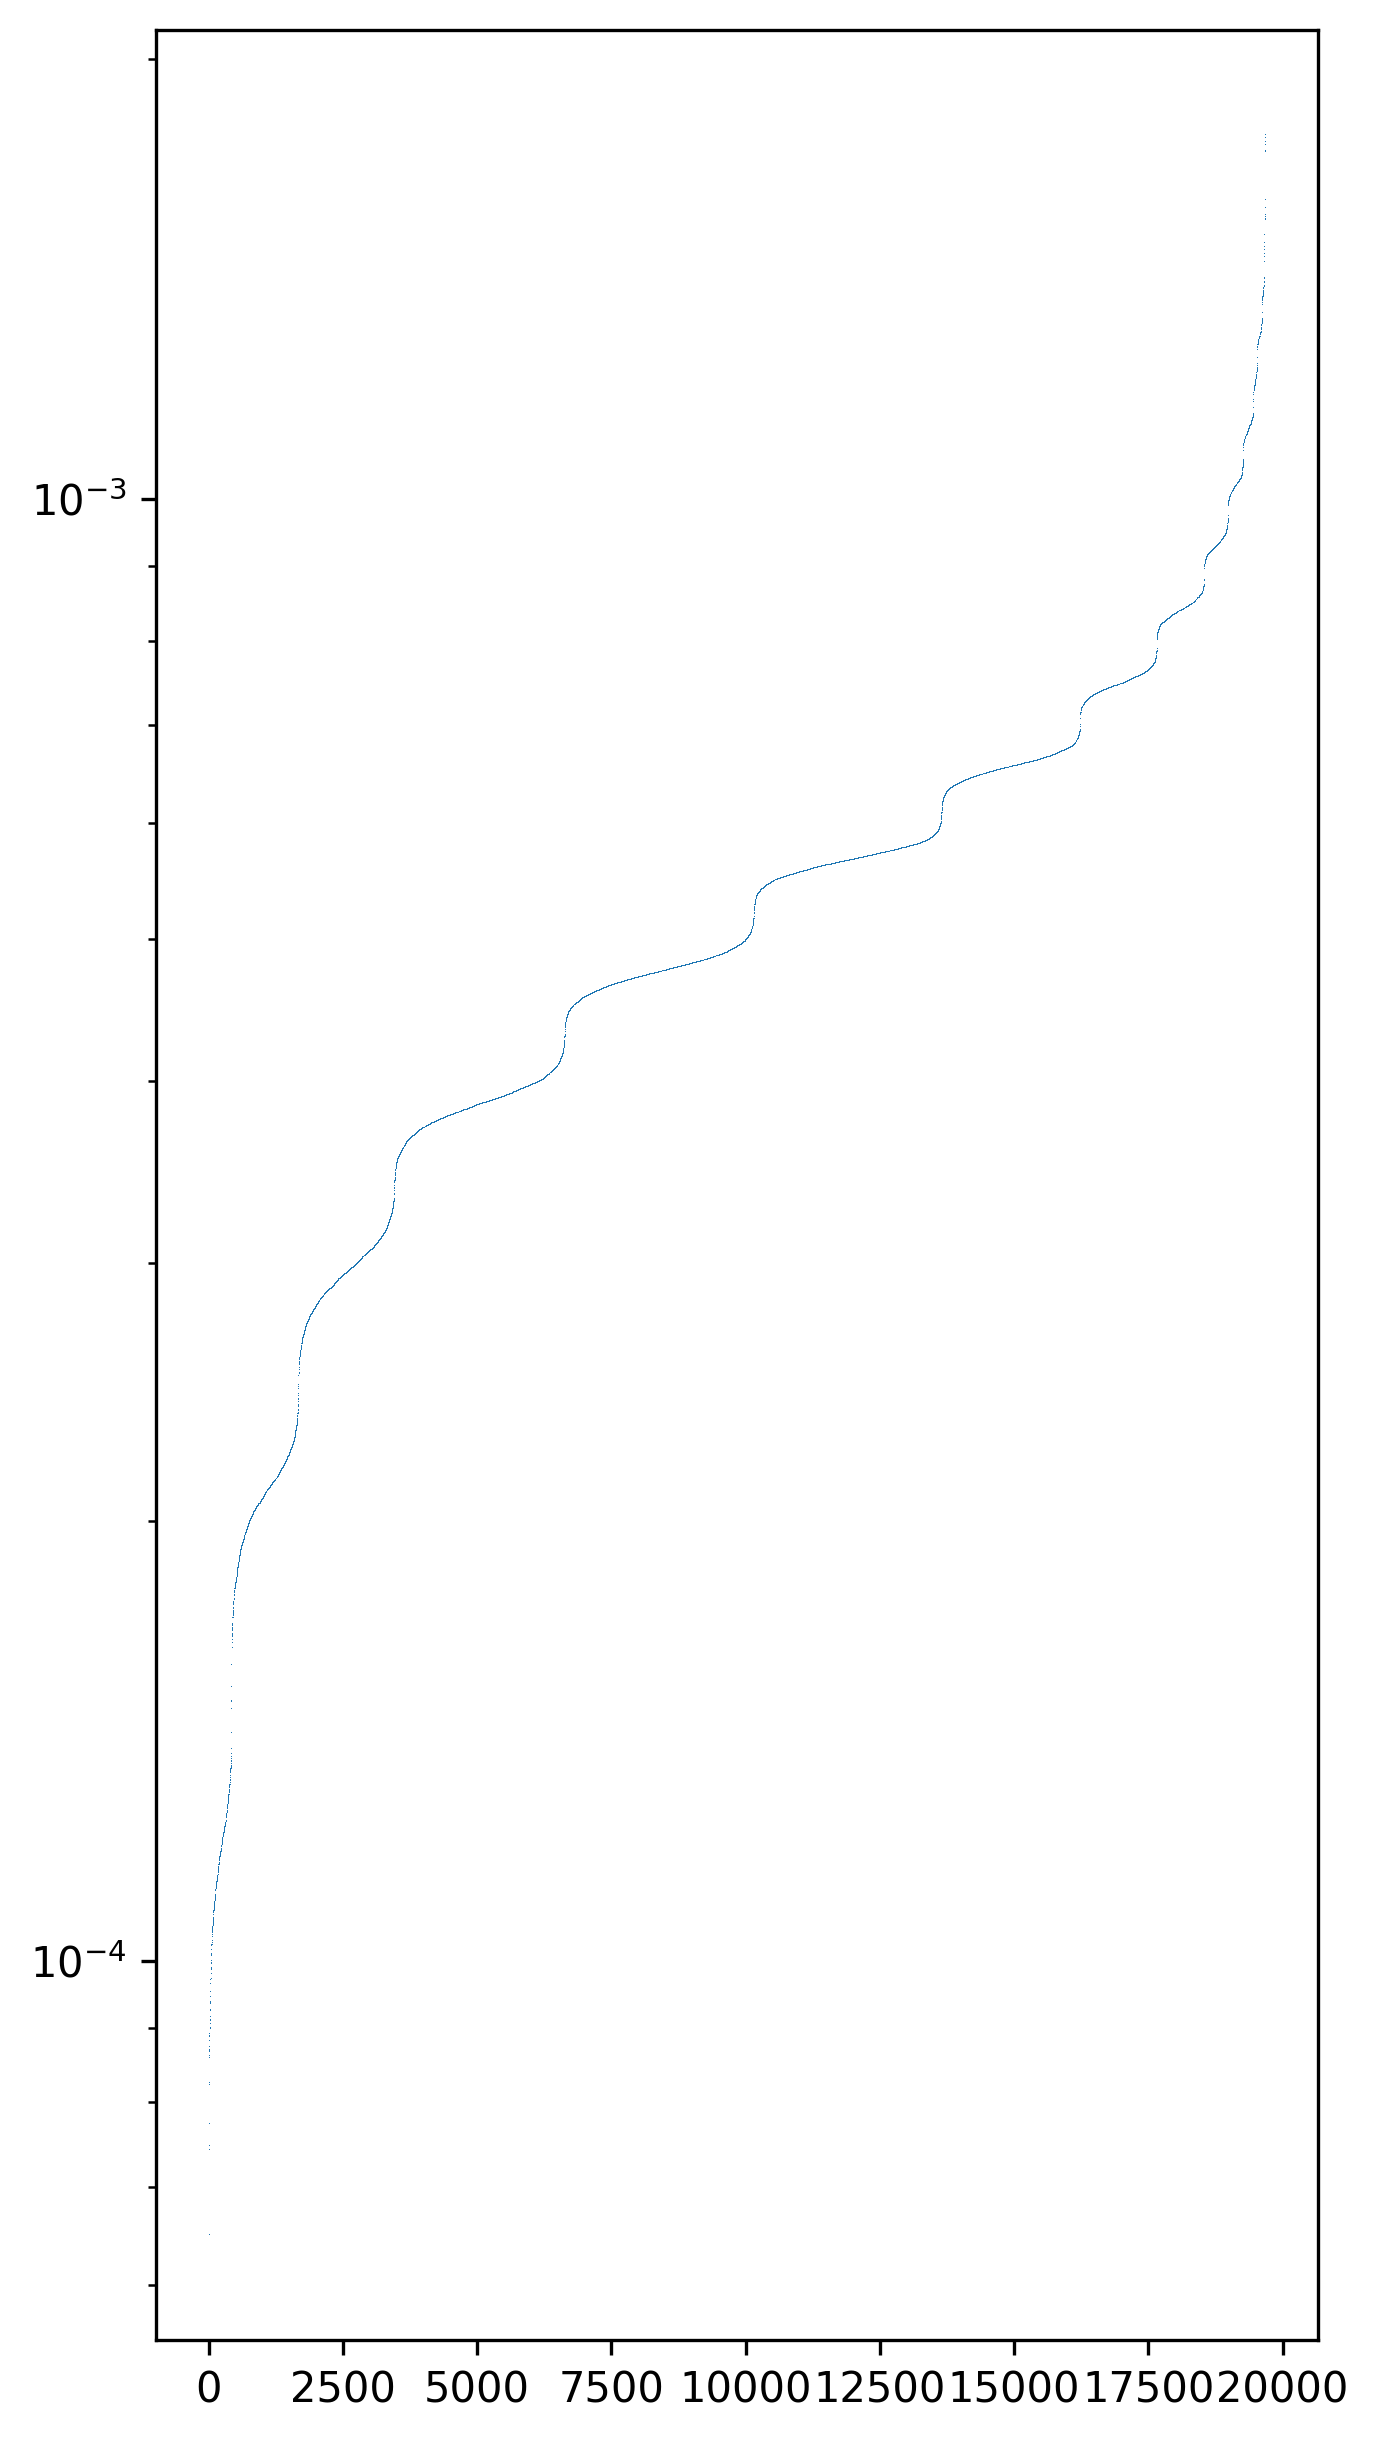

In [19]:
plt.figure(dpi=300, figsize=(5,10))
plt.plot(all_logical_error_rates.sort(), ',')
plt.yscale('log')
plt.show()